In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

import scanpy as sc

import scipy
scipy.__version__

sc.logging.print_versions()

In [15]:
sc.settings.n_jobs=8

In [3]:
path = '/data/xyzeq/xyzeq/individual.raw.and.proc.h5ads/20200319/'

In [4]:
##load the data
adata=sc.read(path + 'matrix_mergedIntron.mtx', cache=False).T




# ##name the genes


adata.var_names = [gene.strip() for gene in open(path + 'genes_10x.tsv', 'r')]



# ##name the cells
adata.obs_names = [barcode.strip() for barcode in open(path + 'barcodes.tsv', 'r')] 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata.obs['barcode']=adata.obs.index.str[-16:]
adata.var_names_make_unique() 
adata=adata[adata.obs_names.str.contains('L20C1')]

In [6]:
adata.obs['n_counts'] = adata.X.sum(axis=1)

Trying to set attribute `.obs` of view, making a copy.


In [7]:
adata.obs['log_counts'] = np.log10(adata.X.sum(axis=1))
mito_genes_mouse=[name for name in adata.var_names if name.startswith(('mm10___mt-'))]
mito_genes_human=[name for name in adata.var_names if name.startswith(('GRCh38_MT-'))] 
#mito_genes=[name for name in adata.var_names if name.startswith(('mm10_mt-', 'hg19_mt-', 'mt-'))]
##create new obs anotation to define percent mito for each cell 
adata.obs['percent_mito_mouse'] = np.sum(adata[:, mito_genes_mouse].X, axis=1) / np.sum(adata.X, axis=1)*100
adata.obs['percent_mito_human'] = np.sum(adata[:, mito_genes_human].X, axis=1) / np.sum(adata.X, axis=1)*100
sc.pp.filter_genes(adata, min_cells=1)

In [8]:
adata.var['log_cells']=np.log10(adata.var['n_cells'])
gene_meta=adata.var.sort_values(by='n_cells')
#gene_meta['gene']=list(range(1,54516))
#gene_meta.plot.scatter(x='gene',y='log_cells')
gene_meta_high=gene_meta[gene_meta['n_cells']>=5000]

In [9]:
##post processing filter minimum UMIS and genes
sc.pp.filter_cells(adata, min_counts=500)#300
sc.pp.filter_cells(adata, min_genes=100)
#sc.pp.filter_cells(adata, max_counts=15000)
#sc.pp.filter_cells(adata, max_genes=2000) 
##post processing filter genes 
#sc.pp.filter_genes(adata, min_cells=2)
#sc.pp.filter_genes(adata, max_cells=8000)   
# ## define mito genes 
# mito_genes_mouse=[name for name in adata.var_names if name.startswith(('mm10___mt-'))]                 
# mito_genes_human=[name for name in adata.var_names if name.startswith(('GRCh38_MT-'))]                                                                
# ##create new obs anotation to define percent mito for each cell 
# adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)*100
# ##create new obs anotation to define UMIs per cell
# adata.obs['n_counts'] = adata.X.sum(axis=1)

In [10]:
contaminating_genes=[
    
    'mm10___Ntrk2', 
    'GRCh38_SMC5',
    'mm10___4930570N18Rik',
    'mm10___mt-Nd2',
    'GRCh38_GLO1',
    'GRCh38_MALAT1',
    'mm10___Pebp4',
    'mm10___Apoe',
    'mm10___mt-Cytb',
    'mm10___Pigr', 
    'mm10___Trf',
    'mm10___Kif5c', 
    'GRCh38_XIST', 
    'GRCh38_COL19A1',
    'GRCh38_ANKRD30BL',
    'mm10___Camk1d',
    'GRCh38_LINC00486',
    'mm10___Alb',
    'GRCh38_SHF',
    'mm10___A530064D06Rik',
    'mm10___Galnt18', 
    'GRCh38_RP4-594L9.2',
    'mm10___Rnf152',
    'mm10___Malat1', 
    'mm10___Foxp4', 
    'mm10___Sema5a', 
    'mm10___Gm42418',
    'mm10___Cmss1', 
    'mm10___Snx24', 
    'GRCh38_RP11-323I15.5' 
    
]
adata.obs['percent_contam'] = np.sum(adata[:, contaminating_genes].X, axis=1) / np.sum(adata.X, axis=1)*100
##filter out outliers
adata = adata[adata.obs['n_genes'] < 15000, :]
adata = adata[adata.obs['n_counts'] < 10000, :]
adata = adata[adata.obs['percent_mito_mouse'] < 1, :]
#adata = adata[adata.obs['percent_mito_human'] < 10, :]

Trying to set attribute `.obs` of view, making a copy.


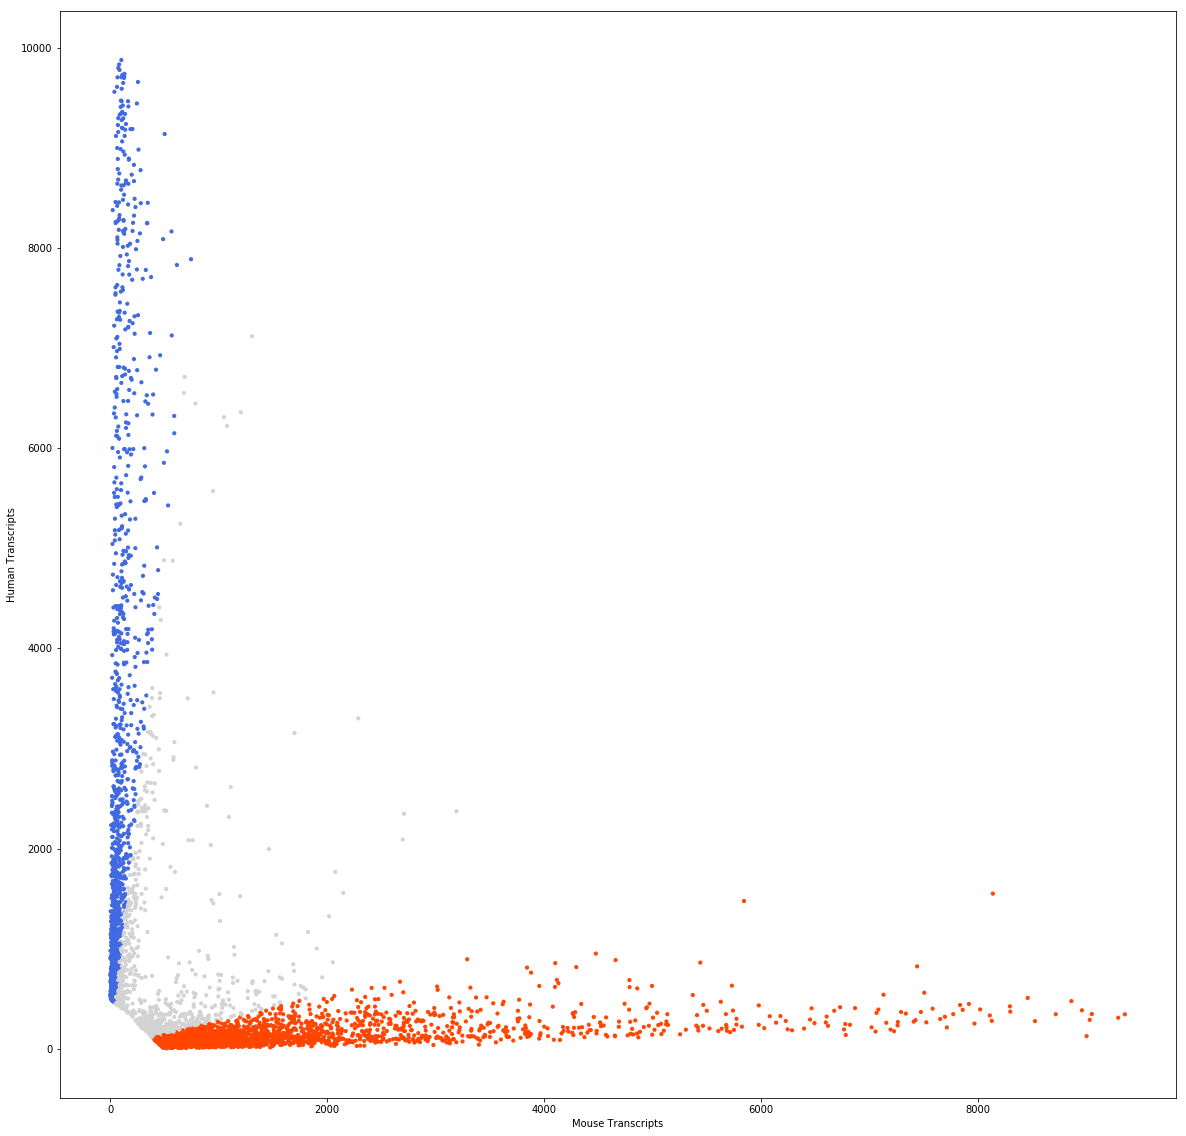

In [11]:
#barnyard
mouse_genes=[name for name in adata.var_names if name.startswith('mm10_')]
#human_genes=[name for name in adata.var_names if name.startswith('GRCh38_')]
human_genes=[name for name in adata.var_names if name.startswith('GRCh38_')]
adata.obs['mouse_counts'] = np.sum(adata[:, mouse_genes].X, axis=1)
adata.obs['human_counts'] = np.sum(adata[:, human_genes].X, axis=1)
# # fig, ax = plt.subplots(figsize=(6, 1))
# fig.subplots_adjust(bottom=0.5)
cmap = mpl.colors.ListedColormap(['royalblue','lightgrey', 'orangered'])
np.seterr(divide = 'ignore') 
adata.obs['ratio'] = np.log10(np.true_divide(adata.obs['mouse_counts'], adata.obs['human_counts']))

def cell_call(counts):
    if counts['ratio'] > 0.66:
        return 'M'
    elif counts['ratio'] < -0.66:
        return 'H'
    else:
        return 'C'

adata.obs['cell_call']=adata.obs.apply(lambda counts: cell_call(counts), axis=1)
plt.rcParams['figure.figsize'] = [20, 20]
plt.scatter(x=adata.obs['mouse_counts'], 
            y=adata.obs['human_counts'],
            s=10,
             c=adata.obs['ratio'],
           cmap=cmap
           )

plt.xlabel('Mouse Transcripts')
plt.ylabel('Human Transcripts')
plt.grid(b=False)
#plt.savefig('/Users/derekbogdanoff/Desktop/L20C1_barnyard.svg', bbox_inches='tight')

In [12]:
adata_vio = adata[adata.obs['cell_call'] != 'C']

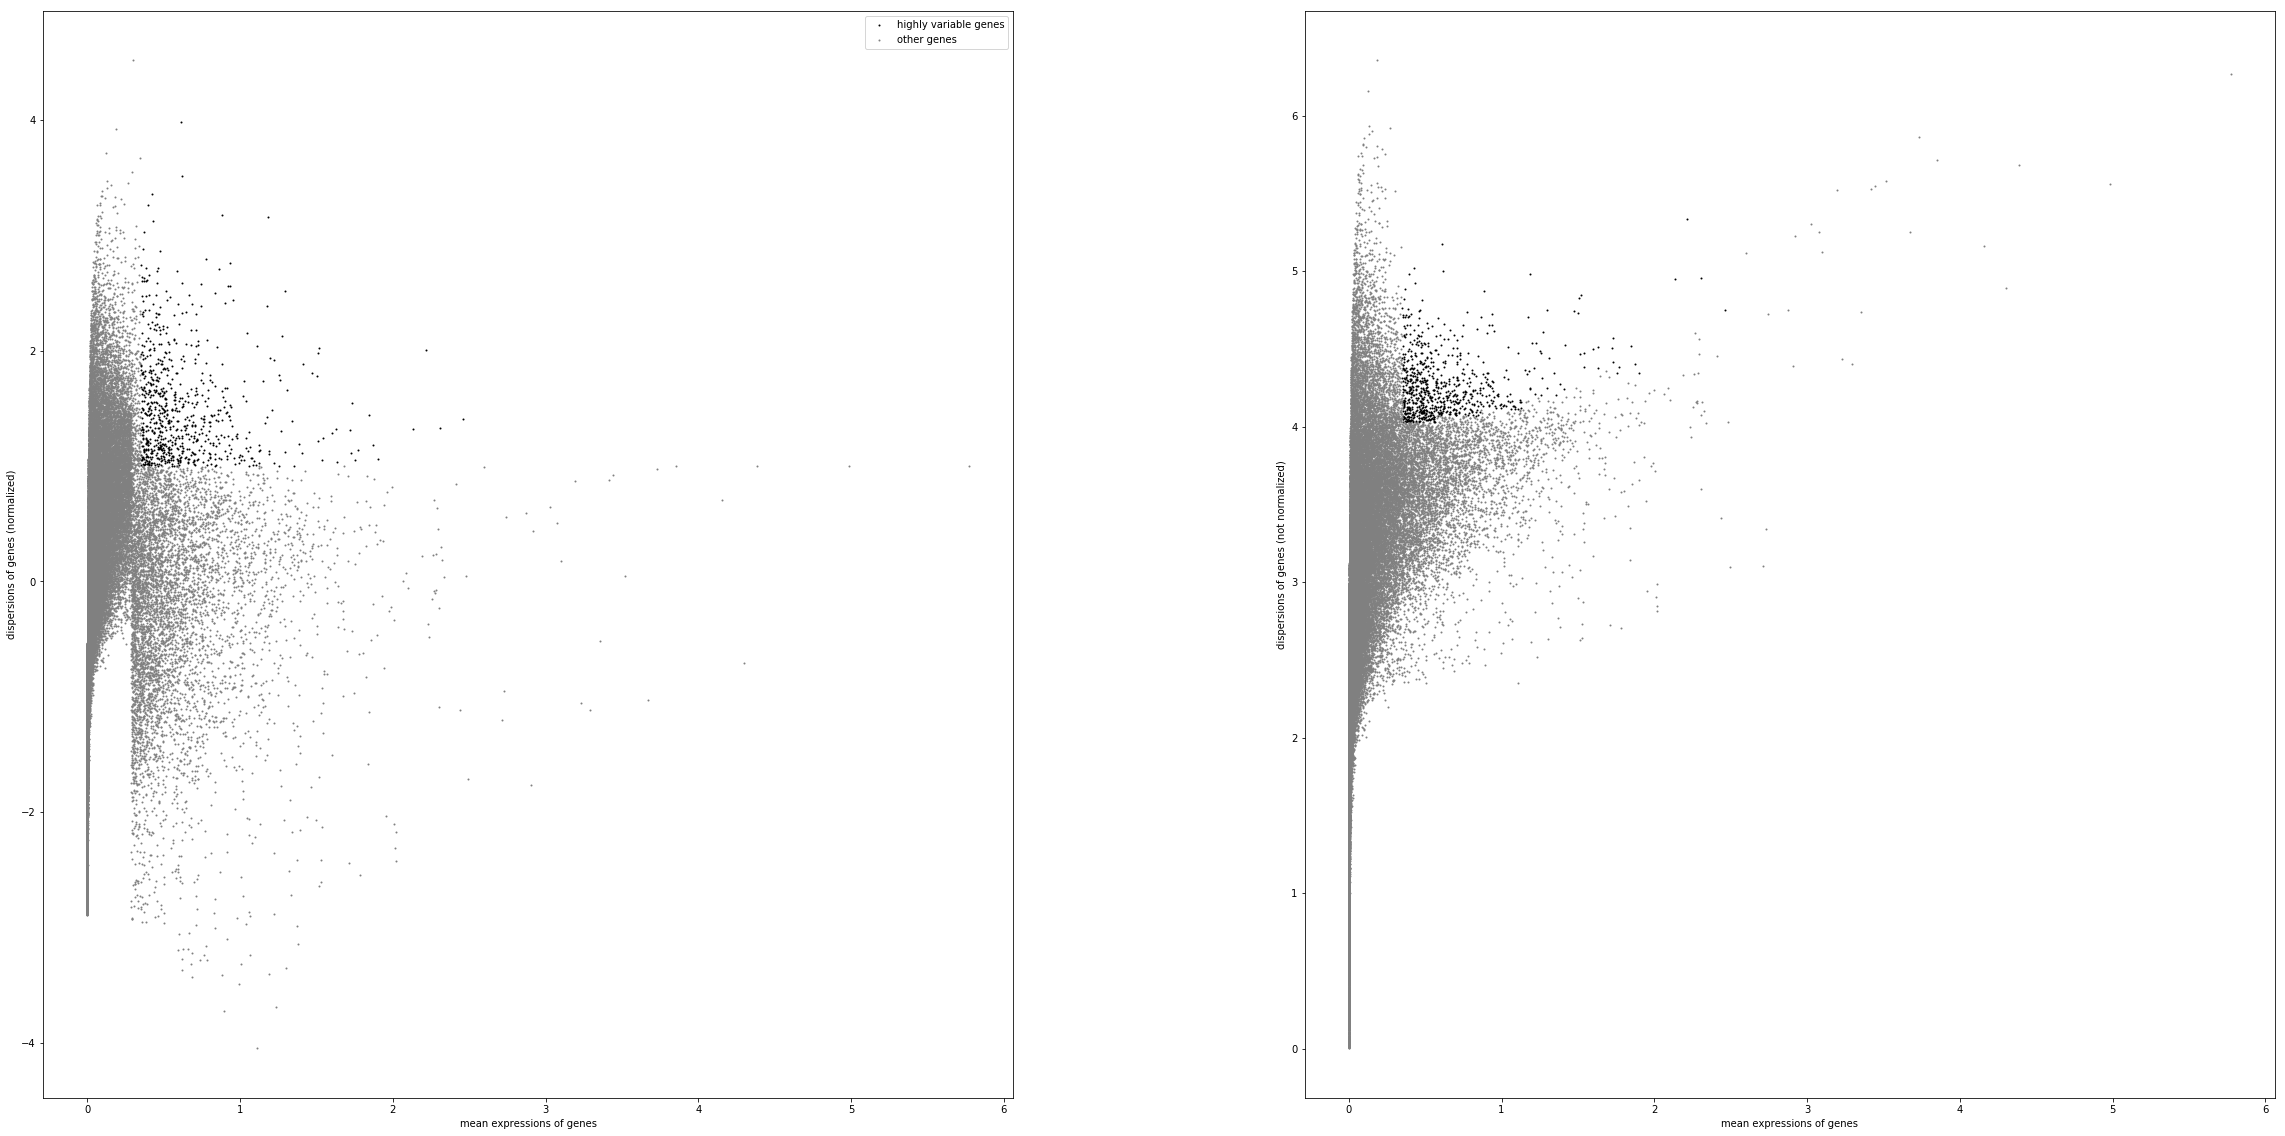

In [13]:
##create raw data file
adata.raw = sc.pp.log1p(adata, copy=True)
##normalize counts per cell to 10K each 
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X,
#    n_top_genes=2000
    min_mean=0.35,
    max_mean=7,
    min_disp=1
                                            ) 
####L20C1 parameters 
sc.pl.filter_genes_dispersion(filter_result)

In [14]:
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

/home/ghartoularos/anaconda3/envs/xyzeq/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [16]:
#Regress out unwanted sources of variation
sc.pp.regress_out(adata, ['n_counts',
              #            'percent_mito_human',
                          'percent_mito_mouse',
              #            'percent_contam'
                         ])

... storing 'barcode' as categorical
... storing 'cell_call' as categorical


In [17]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata,svd_solver='arpack')

In [18]:
sc.pp.neighbors(adata, 
                n_neighbors=10,
                n_pcs=15)

In [19]:
sc.tl.leiden(adata, resolution=0.8)

In [21]:
sc.tl.umap(adata,
           
#              min_dist=.1,
#              spread=2,
#              alpha=2,
            )

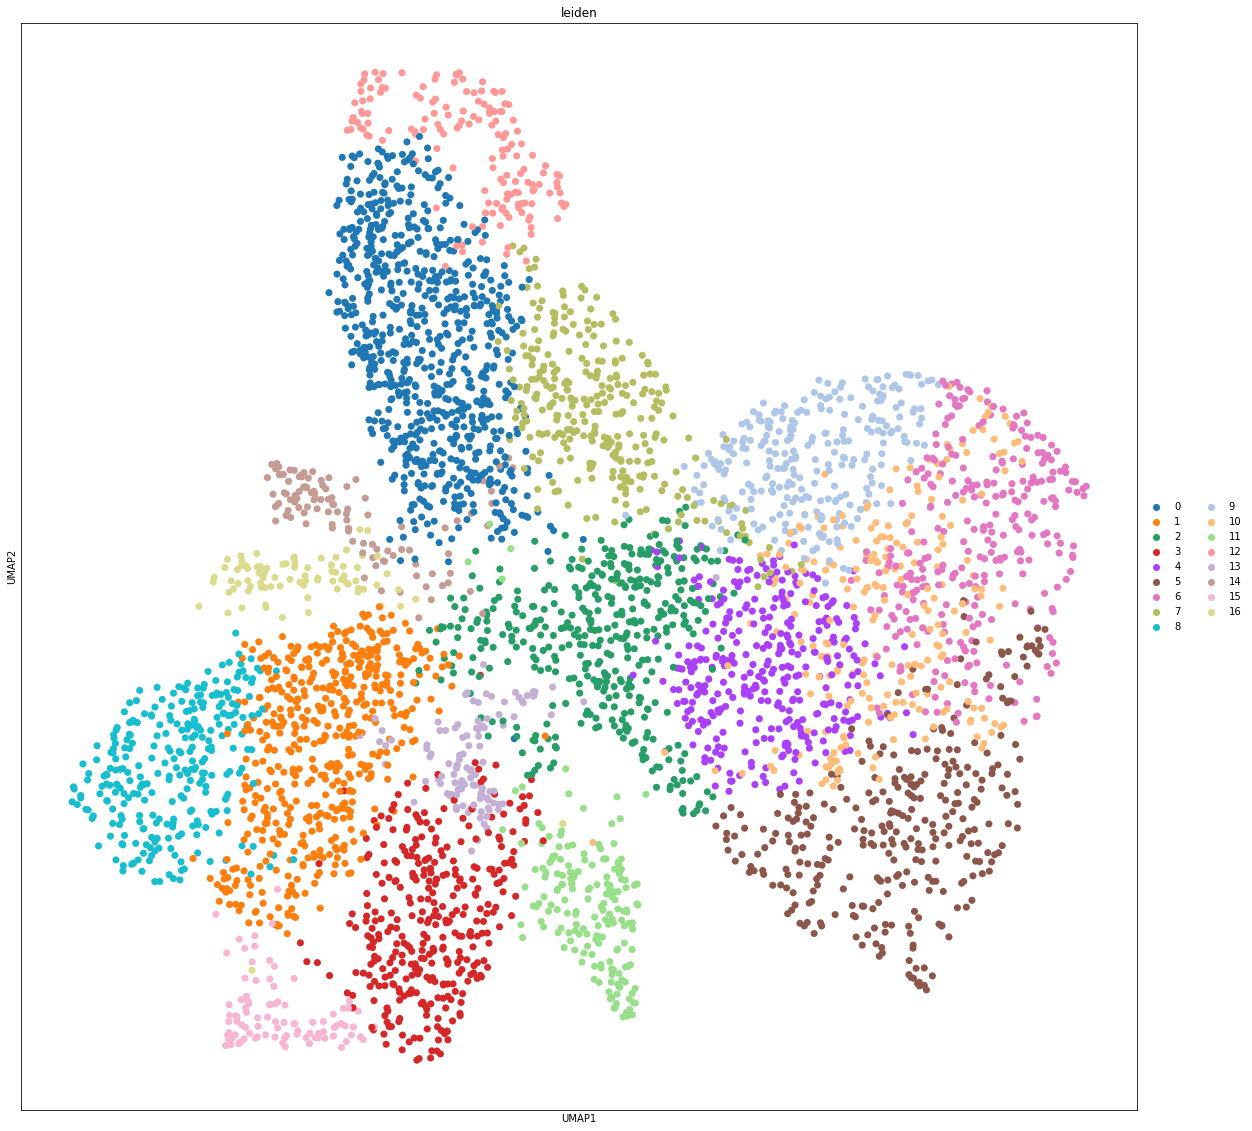

In [22]:

sc.pl.umap(adata, 
           color=['leiden'
                 ],
           ncols=1,
           palette=sc.pl.palettes.default_20,
           color_map=mpl.cm.CMRmap,
      #     legend_loc='on data',
           size=200)

In [23]:
### define new annotation for celltype based on leiden clusters ####

cell_type_df=pd.DataFrame(adata.obs['leiden'])
     
def label (row):
    if row['leiden'] == '0':
        return 'mc38'
    if row['leiden'] =='1':
        return 'Hepatocyte'
    if row['leiden'] == '2':
        return 'Hepatocyte'
    if row['leiden'] == '3':
        return 'Hek293t'
    if row['leiden']  == '4':
        return 'Hek293t'
    if row['leiden'] == '5':
        return 'Macrophage'
    if row['leiden'] == '6':
        return 'Hek293t'
    if row['leiden'] == '7':
        return 'Hek293t'
    if row['leiden'] == '8':
        return 'Hek293t'
    if row['leiden'] == '9':
        return 'Hek293t'
    if row['leiden'] == '10':     
        return 'Kupffer'
    if row['leiden'] == '11':     
        return 'Hepatocyte'
    if row['leiden'] == '12':     
        return 'Lymphocyte'
    if row['leiden'] == '13':     
        return 'LSEC'
    if row['leiden'] == '14':     
        return 'Macrophage' #_CD11b+'
    if row['leiden'] == '15':     
        return 'MSC'
     
     

     
cell_type_df_ =  pd.DataFrame(cell_type_df.apply (lambda row: label(row), axis=1),)

cell_type_df_.columns=['CellType']

adata.obs['CellType']=cell_type_df_

In [27]:
adata.uns['CellType_colors']=[

 '#d9d9d9',    #Hek293t
 '#fb8072', #Hepatocyte
 '#fdb462', #Kupffer
 '#80b1d3', #LSEC
    
 '#bc80bd', #Lymphocyte 
    '#8dd3c7', 
 '#ccebc5', #Macrophage
#    '#9bbf92',#Macrophage_CD11b+
 '#ffed6f',#mc38
        #MSC
]
adata_mouse = adata[adata.obs['CellType'] != 'Hek293t']
sc.tl.tsne(adata_mouse, #_mouse,
           n_pcs=20 )

... storing 'CellType' as categorical


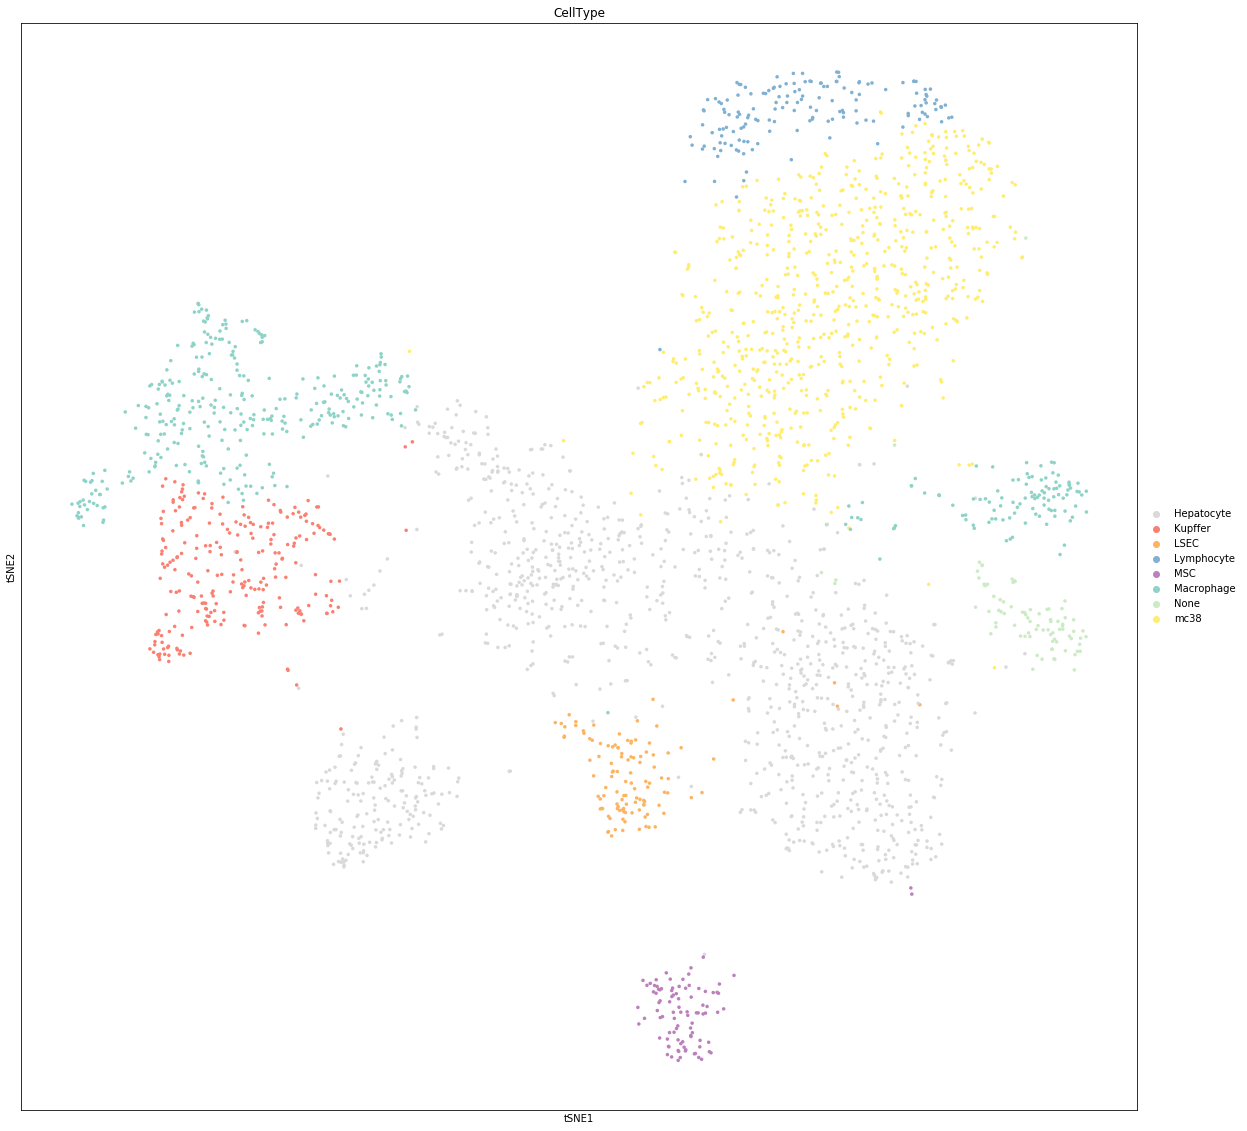

In [28]:
sc.pl.tsne(adata_mouse,
          color=['CellType',
             #   'GRCh38_RP11-323I15.5'
                 #'CellType',
                ],
           s=50
          )



#plt.savefig('/Users/derekbogdanoff/Desktop/tsne.svg', bbox_inches='tight')

In [31]:
sc.tl.rank_genes_groups(adata_mouse,
                        groupby='CellType',
                        method='wilcoxon')
             

sc.tl.filter_rank_genes_groups(adata_mouse,
                              min_fold_change=1.5)
sc.tl.dendrogram(adata_mouse,
                groupby='CellType')

adata_mouse.uns['CellType_colors']=[

# '#d9d9d9',    #Hek293t
 '#fb8072', #Hepatocyte
 '#fdb462', #Kupffer
 '#80b1d3', #LSEC
    
 '#bc80bd', #Lymphocyte 
    '#8dd3c7', 
 '#ccebc5', #Macrophage
#    '#9bbf92',#Macrophage_CD11b+
 '#ffed6f',#mc38
        #MSC
]
adata_mouse

AnnData object with n_obs × n_vars = 2961 × 744 
    obs: 'barcode', 'n_counts', 'log_counts', 'percent_mito_mouse', 'percent_mito_human', 'n_genes', 'percent_contam', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'leiden', 'CellType', '__is_in_cluster__'
    var: 'n_cells', 'log_cells'
    uns: 'pca', 'neighbors', 'leiden', 'leiden_colors', 'CellType_colors', 'rank_genes_groups', 'rank_genes_groups_filtered', 'dendrogram_CellType'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

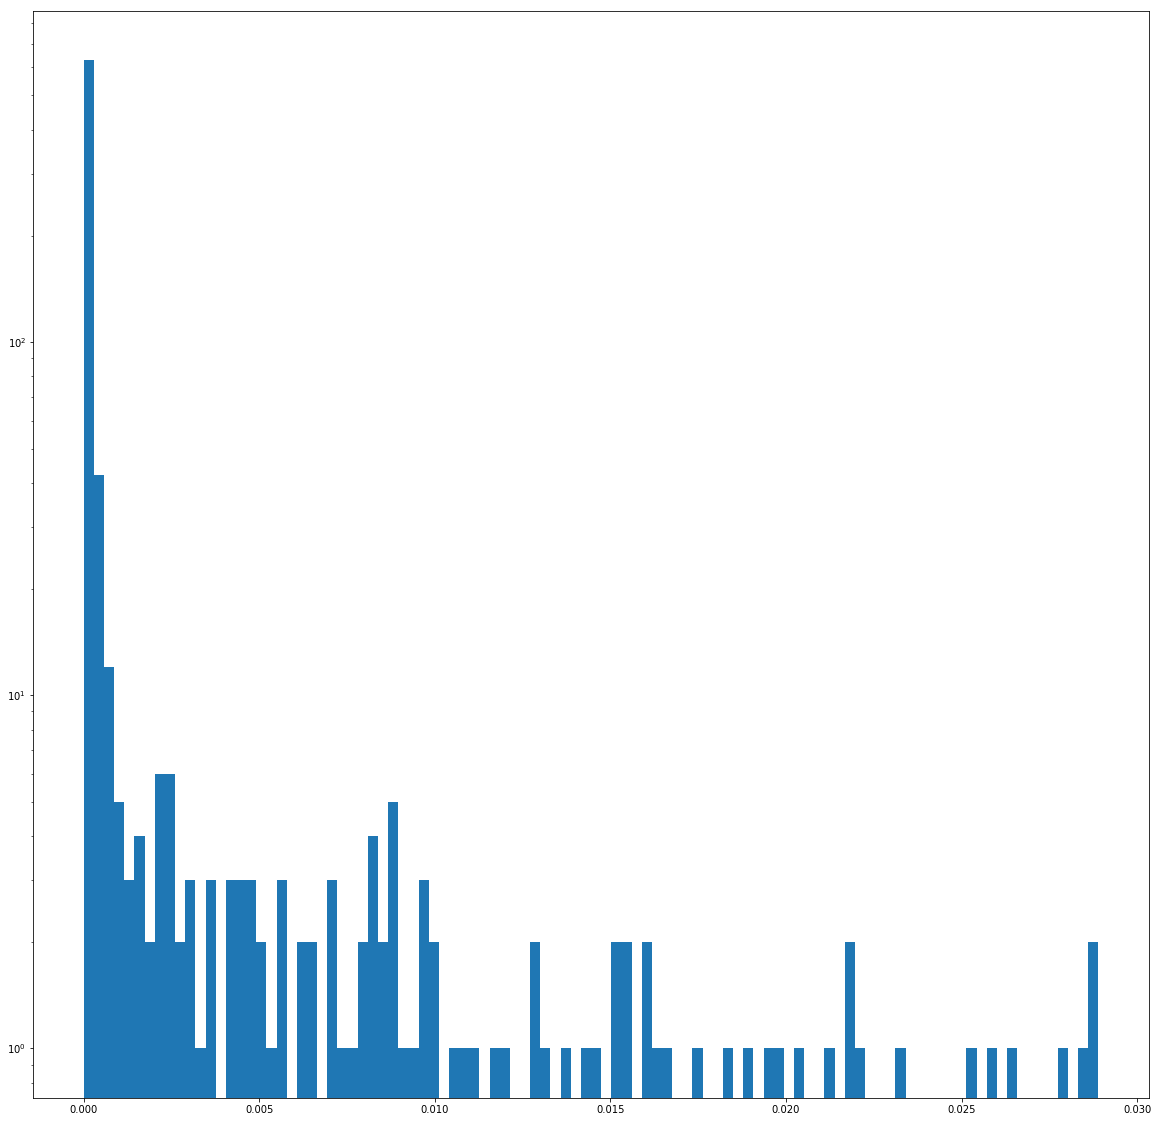

In [68]:
plt.hist(np.array(adata_mouse.uns['rank_genes_groups']['pvals'].tolist()).flatten(), bins=100);
plt.yscale('log')

In [32]:
sc.pl.rank_genes_groups_heatmap(adata_mouse,
                                swap_axes=False,
                                key='rank_genes_groups_filtered',
                                n_genes=200,
                                 vmax=4,
                                 vmin=-1,
                                cmap='viridis'
                                
                               )

categories: Hepatocyte, Kupffer, LSEC, etc.
var_group_labels: Kupffer, LSEC, Lymphocyte, etc.


IndexError: list index out of range